Learn the inter-grid operator ratio for interface problems using multigrid framework,
* Dataset is constructed by changing RHS 
* Restriction and Prolongation operations are followed by a split operation

In [1]:
import torch
import torch.nn as nn
import torch.nn.functional as F

from torch.autograd import Variable
from torch.utils.data import Dataset
from torch.utils.data import DataLoader
from torchvision.transforms import ToTensor

import os
import h5py
import scipy.io as sio
import numpy as np
import matplotlib.pyplot as plt
import math
import random

from FEANet.mesh import MeshHandler
from FEANet.geo import Geometry
from FEANet.jacobi import JacobiBlock
from FEANet.model import KNet, FNet
from Utils import plot

In [2]:
class RHSDataSet(Dataset):
    def __init__(self, h5file, case='train', transform=None, target_transform=None):
        """
        case = 'train' or 'test'
        """
        h5 = h5py.File(h5file,'r')
        self.data = np.array(h5[case], dtype=np.float32)
        self.totensor = ToTensor()
        self.transform = transform
        self.target_transform = target_transform

    def __len__(self):
        return self.data.shape[0]

    def __getitem__(self, idx):
        rhs_tensor = self.totensor(self.data[idx])
        if self.transform:
            rhs_tensor = self.transform(rhs_tensor)
        return rhs_tensor

In [3]:
training_set = RHSDataSet('Data/poisson2d_rhs_17x17.h5', case='train')
test_set = RHSDataSet('Data/poisson2d_rhs_17x17.h5', case='test')

train_dataloader = DataLoader(training_set, batch_size=64, shuffle=True)
test_dataloader = DataLoader(test_set, batch_size=64, shuffle=True)

In [4]:
def random_sampling(v):
    d1, d2, d3, d4 = v.shape
    for i in range(d1):
        for j in range(d2):
            coef = 10*np.random.rand(2) - 5
            v[i, j, :, :] = torch.from_numpy(coef[0]*np.random.random((d3,d4)) + coef[1])

In [5]:
class SingleGrid():
    '''
    Perform weighted Jacobi iteration relaxation for a single grid.
    Note: the n should be the number of intervals, e.g., 
          there are (n+1)*(n+1) grid points in total if the size is n
          f has already been convoluted, i.e., f = fnet(ff) if ff is the sourcing term of PDE
    '''
    def __init__(self, size, n):
        self.size = size # actual size of the plate
        self.n = n 
        self.omega = 2/3.
        self.property = [1, 20] # homogeneous problem
        self.plate = Geometry(nnode_edge = n+1)
        self.grid = MeshHandler(size, prop=self.property, nnode_edge=n+1)
        self.v = torch.zeros((1, 1, n+1, n+1), requires_grad=False, dtype=torch.float32)
        self.f = torch.zeros((1, 1, n+1, n+1), requires_grad=False, dtype=torch.float32)
        self.InstantiateFEANet()
        self.jac = JacobiBlock(self.Knet, self.grid, self.omega, self.plate.geometry_idx, self.plate.boundary_value)

    def IsCoarsest(self):
        return self.n == 2
        
    def InstantiateFEANet(self):
        self.Knet = KNet(self.grid) # Initialize the stiffness network, given mesh
        self.fnet = FNet(self.size/self.n) # Initialize the forcing term network, given mesh size
        for param in self.Knet.parameters():
            param.requires_grad = False
        for param in self.fnet.parameters():
            param.requires_grad = False

    def Relax(self, v, f, num_sweeps_down):
        '''
        Perform a fixed number of weighted Jacobi iteration
        '''
        v = self.jac.jacobi_convolution(v, f, n_iter=num_sweeps_down)
        return v


In [6]:
class RestrictionNet(nn.Module):
    def __init__(self):
        super(RestrictionNet, self).__init__()
        self.n_channel = 16
        self.net = nn.Conv2d(in_channels=self.n_channel,out_channels=1, kernel_size=3, stride=2, bias=False) # restriction
        for i in range(self.n_channel):
            self.net.state_dict()['weight'][0][i] = torch.asarray([[1, 2, 1],
                                                                    [2, 4, 2],
                                                                    [1, 2, 1]], dtype=torch.float32) / 16.0
    def forward(self, x_split):
        '''The input should have already been splitted'''
        return self.net(x_split)

In [7]:
class ProlongationNet(nn.Module):
    def __init__(self):
        super(ProlongationNet, self).__init__()
        self.n_channel = 16
        self.net = nn.ConvTranspose2d(in_channels=self.n_channel,out_channels=1, kernel_size=3, stride=2, padding=1, bias=False) # interpolation
        for i in range(self.n_channel):
            self.net.state_dict()['weight'][i][0] = torch.asarray([[1, 2, 1],
                                                                    [2, 4, 2],
                                                                    [1, 2, 1]], dtype=torch.float32) / 4.0
    def forward(self, x_split): 
        '''The input should have already been splitted'''
        return self.net(x_split)

In [8]:
class MultiGrid(nn.Module):
    '''Define the multigrid problem for 2D, n is the finest grid size'''
    def __init__(self, n = 64):
        super(MultiGrid, self).__init__()

        # Hyper parameters
        self.m = 6 # number of iterations to compute q

        # Problem parameters
        self.size = 2
        self.n = n # number of grid intervals for finest grid edges
        self.L = int(np.log2(n)) # multigrid iteration
        self.solution = []
        
        self.n_arr = self.SizeArray() # array to store grid size for each level
        self.grids = self.GridDict() # dictionary of structure grids
        
        # Inter-grid communication network models
        self.conv = RestrictionNet()
        self.deconv = ProlongationNet()
        self.w = nn.Parameter(torch.asarray([5.,2.], dtype=torch.float32))
        
        self.conv.requires_grad_(False)
        self.deconv.requires_grad_(False)
        self.w.requires_grad_(True)
    
    def GridDict(self):
        grids = {}
        for i in range(self.L):
            grids[i] = SingleGrid(self.size, self.n_arr[i])
        return grids

    def SizeArray(self):
        n_arr = []
        for i in range(self.L):
            n_arr.append(int(self.n/(2.**i)))
        n_arr = np.array(n_arr)
        return n_arr

    def Restrict(self, rF):
        '''
        Perform restriction operation to down sample to next (coarser) level
        Note: rF has already been splitted
        '''
        rFC = self.conv(rF[:, :, 1:-1, 1:-1].clone())
        rFC = F.pad(rFC,(1,1,1,1),"constant",0) # pad the coarse-level residual with zeros
        return rFC

    def Interpolate(self, eFC):
        '''
        Perform interpolation and upsample to previous (finer) level 
        Note: eFC has already been splitted
        '''
        eF = self.deconv(eFC.clone())
        return eF 

    def qm(self, x):
        "Compute the convergence factor after m iterations"
        res1 = self.f - self.grids[0].Knet(x)
        res0 = self.f - self.grids[0].Knet(self.v)
        return torch.mean(torch.pow(torch.norm(res1[:, :, 1:-1, 1:-1].clone(), dim=(2,3))/torch.norm(res0[:, :, 1:-1, 1:-1].clone(), dim=(2,3)).detach(), 1.0/self.m))
    
    def forward(self, F):
        '''Input is RHS field F'''
        self.f = self.grids[0].fnet(F) # assign the finest rhs 
        self.v = torch.zeros_like(F, requires_grad=False, dtype=torch.float32) # initial solution
        random_sampling(self.v)
        U = torch.clone(self.v)
    
        for i in range(self.m-1):
            U = self.iterate(U).detach()
        return self.iterate(U)

    def iterate(self, x):
        '''Input x is the initial solution on the finest grid'''
        n_batches = x.shape[0]
        n_relax = 1 # number of relaxations
        self.grids[0].v = x
        self.grids[0].f = self.f
        self.grids[0].v = self.grids[0].Relax(self.grids[0].v, self.grids[0].f, n_relax)

        for j in range(0, self.L-1):
            rF = self.grids[j].f-self.grids[j].Knet(self.grids[j].v)
            rF = self.grids[j].Knet.split_x(rF)
            self.grids[j+1].f = self.w[0]*self.Restrict(rF)
            self.grids[j+1].v = torch.zeros((n_batches,1,self.n_arr[j+1]+1,self.n_arr[j+1]+1), dtype=torch.float32, requires_grad=False)
            self.grids[j+1].v = self.grids[j+1].Relax(self.grids[j+1].v, self.grids[j+1].f, n_relax)

        self.grids[self.L-1].v = self.grids[self.L-1].Relax(self.grids[self.L-1].v, self.grids[self.L-1].f, n_relax)

        for j in range(self.L-2,-1,-1):
            eFC = self.grids[j+1].Knet.split_x(self.grids[j+1].v)
            eF_delta = self.w[1]*self.Interpolate(eFC)
            self.grids[j].v = self.grids[j].v + eF_delta
            self.grids[j].v = self.grids[j].Relax(self.grids[j].v, self.grids[j].f, n_relax)

            # zero out the previous level solution
            self.grids[j+1].v = torch.zeros((n_batches,1,self.n_arr[j+1]+1,self.n_arr[j+1]+1), dtype=torch.float32, requires_grad=False) 

        return self.grids[0].v 

In [9]:
n = 2**4
model = MultiGrid(n)
rhs = next(iter(train_dataloader))

In [10]:
print(list(model.parameters()))

[Parameter containing:
tensor([5., 2.], requires_grad=True), Parameter containing:
tensor([[[[0.0625, 0.1250, 0.0625],
          [0.1250, 0.2500, 0.1250],
          [0.0625, 0.1250, 0.0625]],

         [[0.0625, 0.1250, 0.0625],
          [0.1250, 0.2500, 0.1250],
          [0.0625, 0.1250, 0.0625]],

         [[0.0625, 0.1250, 0.0625],
          [0.1250, 0.2500, 0.1250],
          [0.0625, 0.1250, 0.0625]],

         [[0.0625, 0.1250, 0.0625],
          [0.1250, 0.2500, 0.1250],
          [0.0625, 0.1250, 0.0625]],

         [[0.0625, 0.1250, 0.0625],
          [0.1250, 0.2500, 0.1250],
          [0.0625, 0.1250, 0.0625]],

         [[0.0625, 0.1250, 0.0625],
          [0.1250, 0.2500, 0.1250],
          [0.0625, 0.1250, 0.0625]],

         [[0.0625, 0.1250, 0.0625],
          [0.1250, 0.2500, 0.1250],
          [0.0625, 0.1250, 0.0625]],

         [[0.0625, 0.1250, 0.0625],
          [0.1250, 0.2500, 0.1250],
          [0.0625, 0.1250, 0.0625]],

         [[0.0625, 0.1250, 0.0625],
 

0 0.029190100729465485
1 0.2949562966823578
2 3.8718366622924805
3 50.294490814208984
4 652.6026611328125
5 8467.138671875
6 109855.125
7 1425288.75
8 18492104.0
9 239921824.0
10 3112803840.0
11 40386297856.0
12 523985879040.0
13 6798338162688.0
14 88202782179328.0
15 1144377124585472.0
16 1.4847501152550912e+16
17 1.9263673928882586e+17
18 2.499316648649949e+18
19 inf
The iteration doesn't converge!


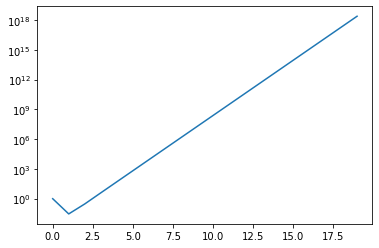

In [11]:
EPS = 5e-5
n_multigrid = 0
u = torch.zeros((1, 1, n+1, n+1), requires_grad=False, dtype=torch.float32)
res_arr = [1]
res = 1
model(rhs[1].unsqueeze(0))
err_occured = False
while (abs(res) > EPS):
    u = model.iterate(u)
    residual = model.f-model.grids[0].Knet(u)
    res_old = res
    res = torch.sqrt(torch.sum(residual[:, :, 1:-1, 1:-1] ** 2)).item()
    res_arr.append(res)
    print(n_multigrid, res)
    n_multigrid += 1

    if(res == torch.inf or math.isnan(res)):
        err_occured = True
        break

if(err_occured):
    print("The iteration doesn't converge!")
else:
    print("Solution converges after", n_multigrid, "multi-grid iterations ")
plt.plot(res_arr)
plt.yscale('log')

In [12]:
model_dir = 'Model/multigrid_rhs'
if not os.path.exists(model_dir):
    os.makedirs(model_dir)
    
optimizer = torch.optim.Adam(model.parameters(), lr=1e-3)
print('Restriction kernel:', model.conv.net.weight[0][0])
print('Interpolation kernel:', model.deconv.net.weight[0][0])
print('Ratio:', model.w[:])

Restriction kernel: tensor([[0.0625, 0.1250, 0.0625],
        [0.1250, 0.2500, 0.1250],
        [0.0625, 0.1250, 0.0625]])
Interpolation kernel: tensor([[0.2500, 0.5000, 0.2500],
        [0.5000, 1.0000, 0.5000],
        [0.2500, 0.5000, 0.2500]])
Ratio: tensor([5., 2.], grad_fn=<SliceBackward0>)


In [13]:
def train_one_epoch():
    running_loss = 0.
    for i, data in enumerate(train_dataloader):
        optimizer.zero_grad() # zero the gradients for every batch
        u_out = model(data)
        loss_q = model.qm(u_out)
        
        loss_q.backward()
        optimizer.step()
        running_loss += loss_q.item()
    
    last_loss = running_loss/(i+1)
    return last_loss

In [14]:
num_epoch = 300
best_vloss = 1_000_000.

qm_train = []
for epoch in range(num_epoch):
    model.train(True)
    avg_q = train_one_epoch()
    print(epoch, avg_q)
    
    # Track best performance, and save the model's state
    mpath = os.path.join(model_dir,'model_multigrid_interface_ratio.pth')
    torch.save(model.state_dict(), mpath)
    qm_train.append(avg_q)

0 6.645969927310944
1 6.413676738739014
2 6.2537078857421875
3 5.927857726812363
4 5.807199567556381
5 5.48435315489769
6 5.388522684574127
7 5.148074209690094
8 5.028692901134491
9 4.8466856777668
10 4.624854177236557
11 4.506750643253326
12 4.36715304851532
13 4.257739007472992
14 4.019375830888748
15 3.9815188348293304
16 3.8361689746379852
17 3.692592829465866
18 3.5782675594091415
19 3.481964036822319
20 3.344178095459938
21 3.2351738065481186
22 3.107434183359146
23 3.0118578672409058
24 2.9331030547618866
25 2.863951712846756
26 2.7471294701099396
27 2.627696067094803
28 2.56516070663929
29 2.453726962208748
30 2.395810753107071
31 2.312870040535927
32 2.220618709921837
33 2.173089012503624
34 2.0792278945446014
35 1.9971996694803238
36 1.9602058455348015
37 1.8960647135972977
38 1.8404264450073242
39 1.770078383386135
40 1.7269055917859077
41 1.684656746685505
42 1.6102502718567848
43 1.5567706674337387
44 1.4923210516571999
45 1.4563356712460518
46 1.4179600179195404
47 1.3742

AttributeError: 'RestrictionNet' object has no attribute 'weight'

New ratio: tensor([4.1108, 0.9840], grad_fn=<SliceBackward0>)


Text(0.5, 0, 'epoch')

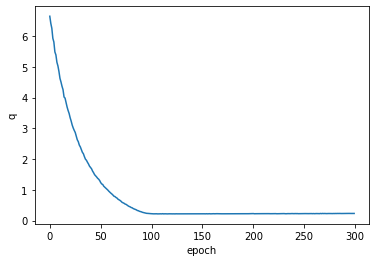

In [15]:
print('New ratio:', model.w[:])
plt.plot(qm_train)
plt.ylabel('q')
plt.xlabel('epoch')

In [16]:
# import the learned model
model.load_state_dict(torch.load(os.path.join(model_dir,'model_multigrid_interface_ratio.pth')))
model.w

Parameter containing:
tensor([4.1108, 0.9840], requires_grad=True)

In [17]:
EPS = 5e-5
n_multigrid = 0
n = 2**4
u = torch.zeros((1, 1, n+1, n+1), requires_grad=False, dtype=torch.float32)
res_arr = [1]
res = 1
model(rhs[0].unsqueeze(0))
while (abs(res) > EPS):
    u = model.iterate(u)
    residual = model.f-model.grids[0].Knet(u)
    res_old = res
    res = torch.sqrt(torch.sum(residual[:, :, 1:-1, 1:-1] ** 2)).item()
    res_arr.append(res)
    print(n_multigrid, res)
    n_multigrid += 1

print("Solution converges after", n_multigrid, "multi-grid iterations ")

0 0.15215571224689484
1 0.054416924715042114
2 0.02104109153151512
3 0.008035090751945972
4 0.003045672085136175
5 0.00115576246753335
6 0.0004414913128130138
7 0.00016977806808426976
8 6.603574001928791e-05
9 2.5853567422018386e-05
Solution converges after 10 multi-grid iterations 


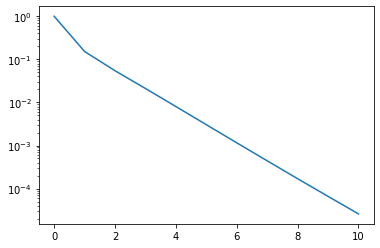

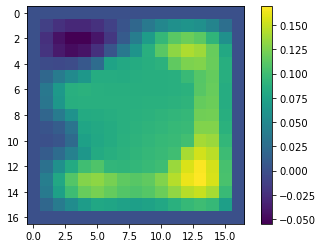

In [18]:
plt.plot(res_arr)
plt.yscale('log')
plot.plot_field(u.detach())

In [19]:
# Test the multigrid iteration
class Multigrid():
    '''Define the multigrid problem for 2D, n is the finest grid size'''
    def __init__(self, inter_model, n = 64):

        self.size = 2
        self.n = n # total number of grids for finest grid
        self.L = int(np.log2(n)) # number of levels for V-cycle multigrid
        self.x = np.linspace(-1,1,n+1, dtype=np.float32) # grid number is n+1
        self.y = np.linspace(-1,1,n+1, dtype=np.float32)
        self.xx, self.yy = np.meshgrid(self.x, self.y, indexing='xy')
        self.solution = []

        self.w = inter_model.w.detach()
        self.conv = inter_model.conv
        self.deconv = inter_model.deconv
        self.conv.requires_grad_(False)
        self.deconv.requires_grad_(False)
        
        self.n_arr = self.SizeArray() # array to store grid size for each level
        self.grids = self.GridDict() # dictionary of structure grids
        
        ff = np.ones_like(self.xx)
        self.grids[0].f = self.grids[0].fnet(torch.from_numpy(ff.reshape(1,1,n+1,n+1))) # assign the finest right hand side with the original rhs

    def GridDict(self):
        grids = {}
        for i in range(self.L):
            grids[i] = SingleGrid(self.size, self.n_arr[i])
        return grids

    def SizeArray(self):
        n_arr = []
        for i in range(self.L):
            n_arr.append(int(self.n/(2.**i)))
        n_arr = np.array(n_arr)
        return n_arr

    def Restrict(self, rF):
        '''
        Perform restriction operation to down sample to next (coarser) level
        Note: rF has already been splitted
        '''
        rFC = self.conv(rF[:, :, 1:-1, 1:-1].clone())
        rFC = F.pad(rFC,(1,1,1,1),"constant",0) # pad the coarse-level residual with zeros
        return rFC

    def Interpolate(self, eFC):
        '''
        Perform interpolation and upsample to previous (finer) level 
        Note: eFC has already been splitted
        '''
        eF = self.deconv(eFC.clone())
        return eF 

    def Error(self,v):
        '''
        Compute the error between current approximation and exact solution
        v should be a 1D vector
        '''
        return torch.linalg.norm(v.reshape(-1)-self.u_exact.reshape(-1), ord=torch.inf)
    
    def rec_V_cycle(self, l, v, f):
        '''
        Perform recursive V-cycle
        Input: l, current level
        '''
        n_sample = 1
        self.grids[l].v = v
        self.grids[l].f = f
        self.grids[l].v = self.grids[l].Relax(v, f, n_sample)
        if(not self.grids[l].IsCoarsest()):
            residual = self.grids[l].f-self.grids[l].Knet(self.grids[l].v)
            residual = self.grids[l].Knet.split_x(residual)
            self.grids[l+1].f = self.w[0]*self.Restrict(residual)
            self.grids[l+1].v *= 0.
            self.rec_V_cycle(l+1, self.grids[l+1].v, self.grids[l+1].f)
            eFC = self.grids[l+1].Knet.split_x(self.grids[l+1].v)
            self.grids[l].v += self.w[1]*self.Interpolate(eFC)
            self.grids[l+1].v *= 0.
        
        self.grids[l].v = self.grids[l].Relax(self.grids[l].v,self.grids[l].f,n_sample) 

    def Solve(self):
        '''Return error and residual array'''
        EPS = 5e-5
        n_Vcycle = 0
        self.grids[0].v = torch.zeros((1, 1, self.n+1, self.n+1), requires_grad=False, dtype=torch.float32)
        e_Vcycle, res = 1, 1
        e_arr_Vcycle = [e_Vcycle]
        res_arr_Vcycle = [res]
        err_occured = False
        while (res > EPS):
            u_prev = self.grids[0].v 
            self.rec_V_cycle(0,self.grids[0].v,self.grids[0].f)
            e_Vcycle = torch.sqrt(torch.sum((self.grids[0].v - u_prev) ** 2)).item() / torch.sqrt(torch.sum((self.grids[0].v) ** 2)).item()
            e_arr_Vcycle.append(e_Vcycle)
            residual = self.grids[0].f-self.grids[0].Knet(self.grids[0].v)
            res = torch.sqrt(torch.sum(residual[:, :, 1:-1, 1:-1] ** 2)).item()
            res_arr_Vcycle.append(res)
            print(e_Vcycle, res)
            n_Vcycle += 1
            if(res == torch.inf or math.isnan(res)):
                err_occured = True
                break

        if(err_occured):
            print("The iteration doesn't converge!")
        else:
            print("Solution converges after", n_Vcycle, "V-cycle iterations with relative error of", e_Vcycle)
        return e_arr_Vcycle, res_arr_Vcycle

1.0 0.09703924506902695
0.02483156891740659 0.02700534649193287
0.008440645856477014 0.011128471232950687
0.0025611263374668925 0.004846785683184862
0.001134118277094218 0.002169479848816991
0.0005085681061344524 0.0009826291352510452
0.00023492830719294344 0.0004489283310249448
0.00010636958051740793 0.0002055365330306813
4.9948901424646275e-05 9.436738037038594e-05
2.744190509262492e-05 4.4615186197916046e-05
Solution converges after 10 V-cycle iterations with relative error of 2.744190509262492e-05


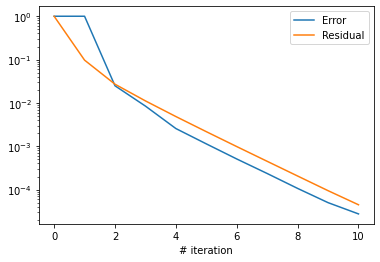

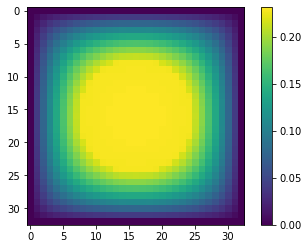

In [20]:
# Multigrid implementation
n = 2**5
prob_mg = Multigrid(model, n)

e_arr_Vcycle, res_arr_Vcycle = prob_mg.Solve()

plt.plot(e_arr_Vcycle, label='Error')
plt.plot(res_arr_Vcycle, label='Residual')
plt.yscale('log')
plt.xlabel('# iteration')
#plt.ylabel('Error')
plt.legend()

plot.plot_field(prob_mg.grids[0].v.detach())

In [21]:
def compute_q(res_arr):
    return np.power(res_arr[9]/res_arr[6], 1.0/4)

print("q is: ", compute_q(res_arr_Vcycle))

q is:  0.556683136588597
